In [91]:
import json
import os
import pandas as pd
import pprint
import time
import numpy as np

%matplotlib inline

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split



import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.callbacks import EarlyStopping


try:
  from pyforest import *
except:
  !pip install pyforest
  from pyforest import *

print(tf.test.gpu_device_name())

from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

from keras import backend as K
print(K.tensorflow_backend._get_available_gpus())


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 15743897920109294832
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 3308119542262191820
physical_device_desc: "device: XLA_CPU device"
]
[]


In [92]:
#from google.colab import files

#uploaded = files.upload()

!wget https://gitlab.com/DBertazioli/enercibiddding/raw/master/PyScripts/q_p_list.pickle
    
with open("q_p_list.pickle", "rb") as infile:
  S=pickle.load(infile)

S1=S[1]
#S1.head()

S1=pd.Series(S1)






scaler = MinMaxScaler()
S1 = scaler.fit_transform(S1.values.reshape(-1,1))

#plt.plot(S1)
X_train, X_test, y_train, y_test = train_test_split(S1[:-1], S1[1:], test_size=0.33, random_state=None, shuffle=False)

--2019-09-04 10:17:26--  https://gitlab.com/DBertazioli/enercibiddding/raw/master/PyScripts/q_p_list.pickle
Resolving gitlab.com (gitlab.com)... 35.231.145.151
Connecting to gitlab.com (gitlab.com)|35.231.145.151|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11150446 (11M) [application/octet-stream]
Saving to: ‘q_p_list.pickle.11’

q_p_list.pickle.11  100%[===================>]  10,63M  3,87MB/s    in 2,7s    

2019-09-04 10:17:30 (3,87 MB/s) - ‘q_p_list.pickle.11’ saved [11150446/11150446]



In [101]:
# split a univariate sequence into samples
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix > len(sequence)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

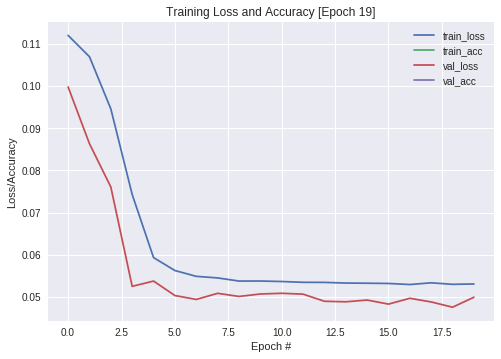

In [ ]:
# choose a number of time steps
n_steps = 24
# split into samples
X, y = split_sequence(S1[:-100], n_steps)
# reshape from [samples, timesteps] into [samples, timesteps, features]
n_features = 1
X = X.reshape((X.shape[0], X.shape[1], n_features))
Xt, yt=split_sequence(S1[-100:], n_steps)
Xt = Xt.reshape((Xt.shape[0], Xt.shape[1], n_features))
#yt=S1[-100+1:]
# define model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(n_steps, n_features),return_sequences=True))
model.add(LSTM(units=50, return_sequences=True))
model.add(LSTM(units=50))
model.add(Dense(units=1))
model.compile(loss='mae', optimizer=tf.train.AdamOptimizer())
# fit model
model.fit(X, y, epochs=30, verbose=0,shuffle=False, validation_split=0.2,callbacks=[EarlyStopping(monitor='val_loss', patience=50),plot_losses])

# demonstrate prediction
yhat = model.predict(Xt, verbose=0)

In [ ]:
plt.figure(figsize=(24,24))
n=10
plt.plot(yhat[:n], color= 'red', label="Predicted")
plt.plot(yt[:n,0], color='green', label="Real")
plt.plot(Xt[:n,23], color='blue', label="Lagged-0")

plt.legend()
plt.show()

In [166]:
for i in range(10):
    print(Xt[i], yt[i], yhat[i])


[[0.19059957]] [0.18169547] [0.21261874]
[[0.18169547]] [0.16265556] [0.20440719]
[[0.16265556]] [0.2569344] [0.18690184]
[[0.2569344]] [0.07374771] [0.27429926]
[[0.07374771]] [0.10345075] [0.10612585]
[[0.10345075]] [0.07077044] [0.13293546]
[[0.07077044]] [0.06777177] [0.10344835]
[[0.06777177]] [0.07564223] [0.1007534]
[[0.07564223]] [0.14536557] [0.10783054]
[[0.14536557]] [0.1508047] [0.17106873]


In [95]:
X_train=X_train.reshape(X_train.shape[0],1,1)#data, timestep/lag, n_features
X_test=X_test.reshape(X_test.shape[0],1,1)

In [96]:
#Callback function for online plot while fitting

from IPython.display import clear_output


class TrainingPlot(keras.callbacks.Callback):
    
    # This function is called when the training begins
    def on_train_begin(self, logs={}):
        # Initialize the lists for holding the logs, losses and accuracies
        self.losses = []
        self.acc = []
        self.val_losses = []
        self.val_acc = []
        self.logs = []
    
    # This function is called at the end of each epoch
    def on_epoch_end(self, epoch, logs={}):
        
        # Append the logs, losses and accuracies to the lists
        self.logs.append(logs)
        self.losses.append(logs.get('loss'))
        self.acc.append(logs.get('acc'))
        self.val_losses.append(logs.get('val_loss'))
        self.val_acc.append(logs.get('val_acc'))
        
        # Before plotting ensure at least 2 epochs have passed
        if len(self.losses)%10==0:
            
            # Clear the previous plot
            clear_output(wait=True)
            N = np.arange(0, len(self.losses))
            
            # You can chose the style of your preference
            # print(plt.style.available) to see the available options
            plt.style.use("seaborn")
            
            # Plot train loss, train acc, val loss and val acc against epochs passed
            plt.figure()
            plt.plot(N, self.losses, label = "train_loss")
            plt.plot(N, self.acc, label = "train_acc")
            plt.plot(N, self.val_losses, label = "val_loss")
            plt.plot(N, self.val_acc, label = "val_acc")
            plt.title("Training Loss and Accuracy [Epoch {}]".format(epoch))
            plt.xlabel("Epoch #")
            plt.ylabel("Loss/Accuracy")
            plt.legend()
            plt.show()

plot_losses = TrainingPlot()

"""train_y=S1[1:4500]
val_y=S1[4500:5500]
test_y=S1[5500:-1]

train_X=S1[2:4501]
val_X=S1[4501:5501]
test_X=S1[5501:]

train_X=np.asarray(train_X).reshape(train_X.shape[0],1, 1)
train_X.shape

test_X=np.asarray(test_X).reshape(test_X.shape[0],1, 1)
test_X.shape

val_X=np.asarray(val_X).reshape(val_X.shape[0], 1, 1)
val_X.shape""";

In [97]:
model = Sequential()
model.add(LSTM(units=10, return_sequences=True,input_dim=1)) #input_shape=(X_train.shape[1],1)))
model.add(LSTM(units=10, return_sequences=True))
model.add(LSTM(units=10))
model.add(Dense(units=1))
model.compile(loss='mae', optimizer=tf.train.AdamOptimizer())

/home/dario/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  
/home/dario/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(units=10, return_sequences=True, input_shape=(None, 1))`
  


In [98]:
%%time

patience=10
# fit network
history = model.fit(X_train, y_train, 
                    epochs=100, 
                    batch_size=32, 
                    validation_split=0.1, 
                    verbose=0, 
                    shuffle=False, 
                    callbacks=[EarlyStopping(monitor='val_loss', patience=patience),plot_losses])

plot=False
if plot:
    %matplotlib inline

    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='test')
    #plt.plot(history.history['acc'], label='train')

    plt.legend()
    plt.show()

ValueError: Input arrays should have the same number of samples as target arrays. Found 1 input samples and 4791 target samples.

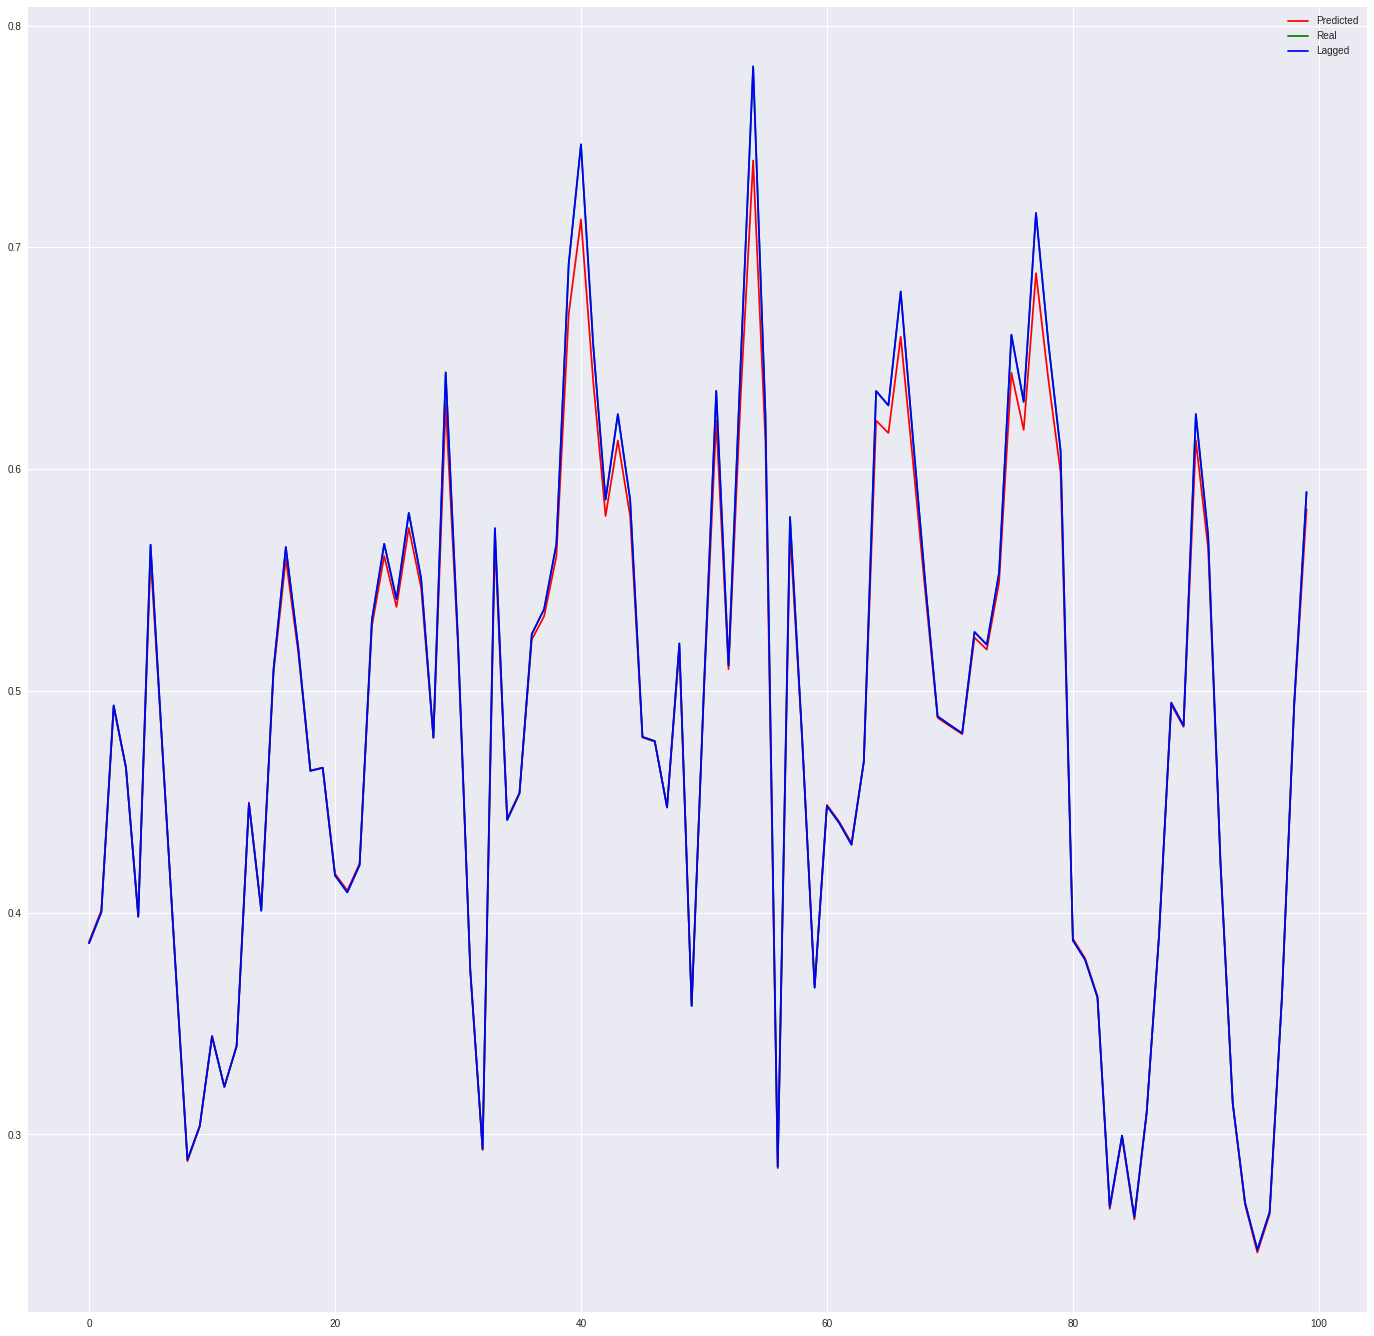

In [87]:
predicted_value= model.predict(X_test)
plt.figure(figsize=(24,24))
n=100
plt.plot(predicted_value[:n], color= 'red', label="Predicted")
plt.plot(y_test[:n,0], color='green', label="Real")
plt.plot(X_test[:n,0], color='blue', label="Lagged")

plt.legend()
plt.show()


In [81]:
score, acc = model.evaluate(X_test, y_test,batch_size=32)
print('Test score:', score)
print('Test accuracy:', acc)

2360/2360 [==============================] - 0s 29us/step


TypeError: 'numpy.float64' object is not iterable

In [72]:
save=True
model_name="lstm_models/LSTM_norm"
model_weights=model_name+"_weigths.h5"
    
if save:
    # serialize model to JSON
    model_json = model.to_json()
    with open(model_name+".json", "w") as json_file:
        json_file.write(model_json)
    # serialize weights to HDF5
    model.save_weights(model_weights)
    print("Saved model to disk")
    colab=False
    if colab:
        from google.colab import files
        files.download(model_name+".json")
        files.download(weigths_name)

# later...
load=False
if load:
    json_file = open(model_name+".json", 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = model_from_json(loaded_model_json)
    # load weights into new model
    loaded_model.load_weights(weigths_name)
    print("Loaded model from disk")

recompile=False
if recompile:
    loaded_model.compile(loss='mae', optimizer=tf.train.AdamOptimizer())

Saved model to disk
